<a href="https://colab.research.google.com/github/grndnl/w266_final_project/blob/main/Modeling_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Masked Language Model task for prediction of missing part in assembly

In [1]:
!pip install -q sentencepiece
!pip install -q transformers
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from transformers import BertTokenizer, TFBertModel, DataCollatorForLanguageModeling

     |████████████████████████████████| 1.3 MB 4.6 MB/s 
     |████████████████████████████████| 5.3 MB 5.3 MB/s 
     |████████████████████████████████| 163 kB 43.4 MB/s 
     |████████████████████████████████| 7.6 MB 22.4 MB/s 


### Pre-process data for task

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = "/content/drive/My Drive/w266/data.csv"
data = pd.read_csv(data_path)

In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data = data.dropna(subset=["assembly_name", "part_names"])
data = data.drop(columns=["assembly_id"])
data

,assembly_name,assembly_description,part_names
0,Lava Lamp 2,NaN,"['Glass', 'Cap', 'Blob3', 'Blob1', 'Blob2']"
1,Sample - Headphones,NaN,"['Telescope hinge', 'Upper band']"
5,Dave's Handsome Mug,NaN,"['Vessel', 'Lid', 'Seal']"
9,Mechanical Pencil,NaN,"['Rubber Grip', 'Eraser', 'Lead Gripper', 'But..."
10,OS kinematics,NaN,"['peg', 'block', 'plate', 'wheel', 'link']"
...,...,...,...
456707,SkateBoard - Copy,NaN,"['Wheel2', 'Spacer2', 'Kingpin', 'SPACER', 'Ca..."
456741,Untitled document,NaN,"['Leg', 'Main_Frame', 'Pin_2.54x12', 'Motor Co..."
456772,PERRINN F1 aero - Copy,NaN,"['mirror', 'end plate', 'master', 'floor', 'di..."
456788,2017-2018 9889,NaN,"['BRACKET-R', 'BRACKET-L', 'PIN', 'WHEEL-HUB-O..."


In [6]:
def process_string(string):
    #string = string.lower()
    string = string.replace('_', '')
    string = string.replace('-', '')
    string = string.replace('[', '')
    string = string.replace(']', '')
    string = string.replace('(', '')
    string = string.replace(')', '')
    string = string.replace("'", '')
    string= string.split(',')
    return string

def process_string2(string):
    #string = string.lower()
    string = string.replace('_', '')
    string = string.replace('-', '')
    string = string.replace('[', '')
    string = string.replace(']', '')
    string = string.replace('(', '')
    string = string.replace(')', '')
    string = string.replace("'", '')
    #string= string.split(',')
    return string


In [7]:
strings = []
labels = []
for index, row in tqdm(data.iterrows(), total=len(data)):
  string_split = process_string(str(row['part_names']))
  if len(string_split) > 1:
        #phrase = f"In an assembly called '{row['assembly_name']}' there are the following parts: "
        phrase = f"there are the following parts: "
        for part_name in string_split:
            phrase += f"{part_name}, "
        strings.append(phrase)
        labels.append(row['assembly_name'])
    


100%|██████████| 46341/46341 [00:12<00:00, 3854.06it/s]


In [8]:
labels[1]

'Sample - Headphones'

In [9]:
type(labels)

list

In [38]:
from collections import Counter
  
def unique(list1):
  
    # Print directly by using * symbol
    return(len(Counter(list1)))

unique(labels)/len(labels)

0.7366694719578775

In [42]:
unique(labels)

34138

In [11]:
print(len(strings))
strings[1]

46341


'there are the following parts: Telescope hinge,  Upper band, '

In [12]:
train_strings, test_strings, train_labels, test_labels = train_test_split(strings,labels, test_size=0.2)
print(f"Length of train: {len(train_strings)}")
print(f"Length of test: {len(test_strings)}")
print(f"Length of train: {len(train_labels)}")
print(f"Length of train: {len(test_labels)}")

Length of train: 37072
Length of test: 9269
Length of train: 37072
Length of train: 9269


#Creating Bert Model

In [14]:
max_length = 128
model_checkpoint = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [41]:
# BERT Tokenization of training and test data

num_train_examples = 20000      # set number of train examples - 1500 for realtime demo
num_test_examples = 5000        # set number of test examples - 500 for realtime demo

max_length = 128                 # set max_length

all_train_examples = train_strings
all_test_examples = test_strings

y_train =  train_labels[:num_train_examples]
              
x_train = bert_tokenizer(all_train_examples[:num_train_examples],
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

              

y_test =  test_labels[:num_test_examples]
x_test = bert_tokenizer(all_test_examples[:num_test_examples],
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')


In [43]:
#y_train

In [19]:
def create_bert_classification_model(bert_model,
                                     train_layers=-1,
                                     hidden_size = 200, 
                                     dropout=0.3,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes
    """
    
    bert_model.trainable = True
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    pooled_token = bert_out[1]
    #cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(10, activation='softmax',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                                 metrics='accuracy')

    
    return classification_model

In [20]:
bert_classification_model = create_bert_classification_model(bert_model)

In [21]:
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

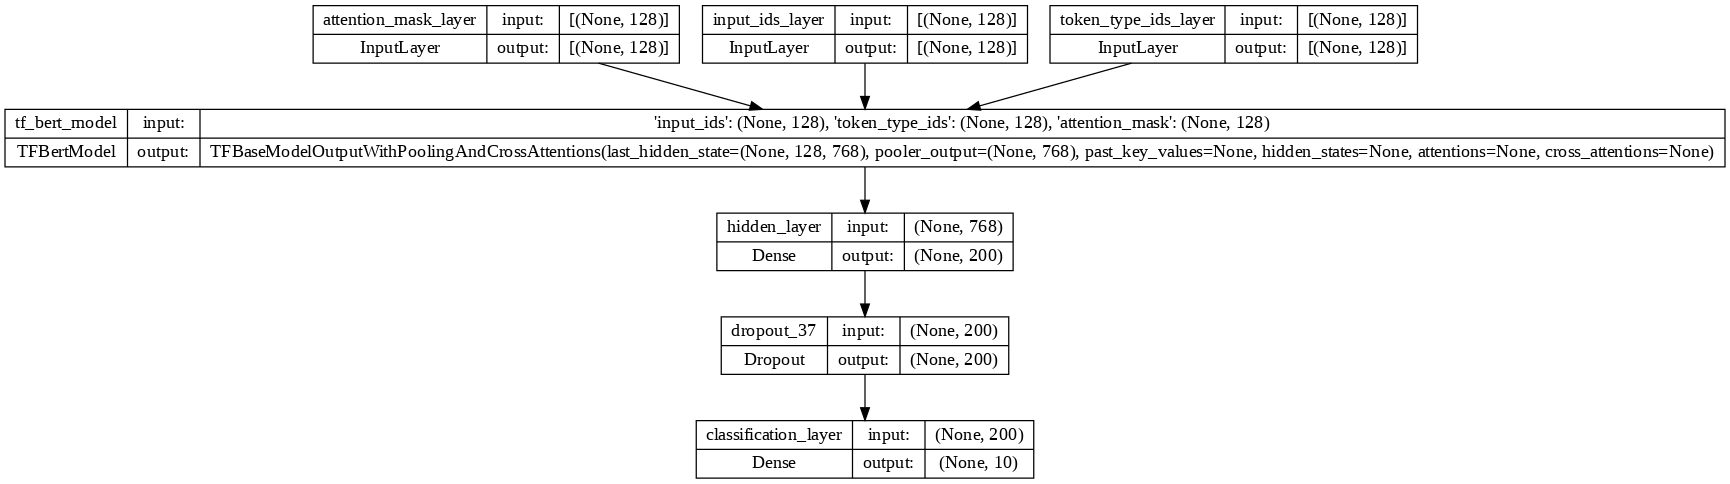

In [22]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [29]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    [y_train.input_ids, y_train.token_type_ids, y_train.attention_mask],
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], [y_test.input_ids, y_test.token_type_ids, y_test.attention_mask]),
    batch_size=32,
    epochs=2
)  

Epoch 1/2


TypeError: ignored